# Training a deep (convolutional) neural network on CIFAR10

In [19]:
# TensorFlow and tf.keras
import tensorflow as tf
import os

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import time
import PIL.Image as Image
from IPython.display import Image, display
import matplotlib.cm as cm

print(tf.__version__)
print(tf.config.list_physical_devices())

2.16.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## 1. Code Convolutions

In [20]:
img =  tf.keras.utils.load_img('Colosseo_2020.jpeg', target_size=(128,128))
data =  tf.keras.utils.img_to_array(img)/255.0
samples = tf.expand_dims(data, 0)


plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

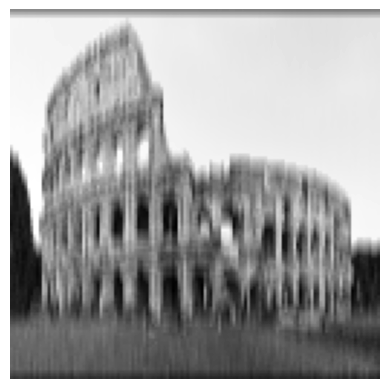

In [ ]:
img =  tf.keras.utils.load_img('Colosseo_2020.jpeg', target_size=(128,128))
data =  tf.keras.utils.img_to_array(img)/255.0
samples = tf.expand_dims(data, 0)

channels = 3


# Create a 7x7 vertical filter and then a horizontal filter
# ATTENTION: Convolutions in keras are 4D, meaning [num_pixels, num_pixels, num_channels, num_filters]

#define the structure of the filter
filter = np.zeros(shape=(7, 7, channels, 1), dtype=np.float32)

#assign the right numerical values to the array (filters weights)
filter[:, 3, :, :] = 1  # vertical line
#filter[3, :, :, :] = 1  # horizontal line


outputs = tf.nn.conv2d(samples, filter, strides=1, padding="SAME")



plt.imshow(outputs[0, :, :, 0], cmap="gray") # plot image's 1nd feature map
plt.axis("off")
plt.show()

## 2. CNN on CIFAR 10

In [ ]:
#setup folder where you will save logs for tensorflow
root_logdir = os.path.join(os.curdir,"my_logs_ML2_CIFAR")


def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)



Import the CIFAR 10 library, split into train, validation and test images.

In [ ]:
cifar = tf.keras.datasets.cifar10

(train_full_images, train_full_labels), (test_images, test_labels) = cifar.load_data()

valid_images, train_images = train_full_images[:5000], train_full_images[5000:]
valid_labels, train_labels = train_full_labels[:5000], train_full_labels[5000:]
test_images = test_images

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

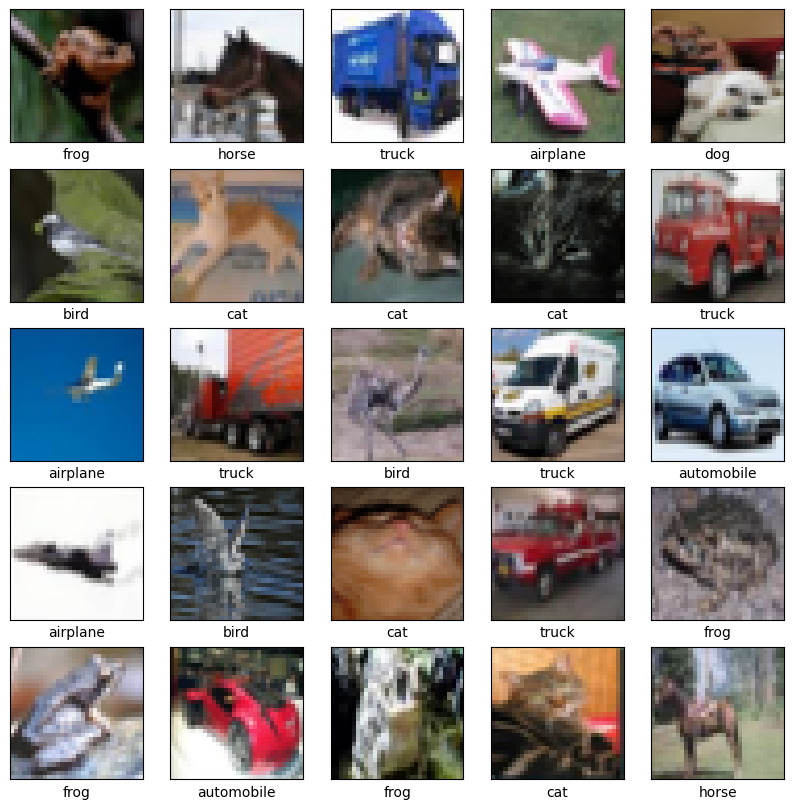

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

Check out some properties of the imported dataset

In [ ]:
print('training ds shape:', train_images.shape)
print('validation ds shape:', valid_images.shape)
print('test ds shape:', test_images.shape)

training ds shape: (45000, 32, 32, 3)
validation ds shape: (5000, 32, 32, 3)
test ds shape: (10000, 32, 32, 3)


In [ ]:
print("labels: ", train_labels)

labels:  [[6]
 [7]
 [9]
 ...
 [9]
 [1]
 [1]]


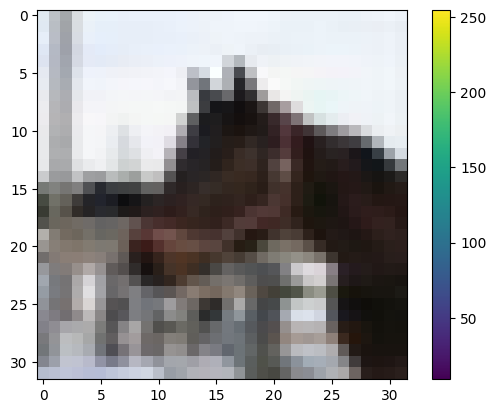

In [ ]:
plt.figure()
plt.imshow(train_images[1])
plt.colorbar()
plt.grid(False)
plt.show()

Normalization of data between 0 and 1

In [ ]:
train_images = train_images / 255.0

valid_images = valid_images / 255.0

test_images = test_images / 255.0

In [ ]:
run_logdir = get_run_logdir()

#create keras Tensorboard callback and early stopping_callback
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
earlystopping_cb  = tf.keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation = 'softmax')
])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 4096)              0

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.99),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.fit(train_images, train_labels, epochs=20, validation_data=(valid_images, valid_labels), callbacks=[tensorboard_cb, earlystopping_cb])

Epoch 1/20


2023-04-28 12:17:01.509025: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1407/1407 [==============================] - 14s 10ms/step - loss: 1.7230 - accuracy: 0.4062 - val_loss: 1.4145 - val_accuracy: 0.5374
Epoch 2/20
1407/1407 [==============================] - 14s 10ms/step - loss: 1.4152 - accuracy: 0.5398 - val_loss: 1.2569 - val_accuracy: 0.5994
Epoch 3/20
1407/1407 [==============================] - 15s 11ms/step - loss: 1.2987 - accuracy: 0.5919 - val_loss: 1.2025 - val_accuracy: 0.6280
Epoch 4/20
1407/1407 [==============================] - 15s 11ms/step - loss: 1.2261 - accuracy: 0.6221 - val_loss: 1.1700 - val_accuracy: 0.6538
Epoch 5/20
1407/1407 [==============================] - 16s 12ms/step - loss: 1.1691 - accuracy: 0.6474 - val_loss: 1.1074 - val_accuracy: 0.6682
Epoch 6/20
1407/1407 [==============================] - 18s 13ms/step - loss: 1.1235 - accuracy: 0.6617 - val_loss: 1.0806 - val_accuracy: 0.6840
Epoch 7/20
1407/1407 [==============================] - 18s 13ms/step - loss: 1.0916 - accuracy: 0.6764 - val_loss: 1.0107 - val_accura

In [ ]:
%load_ext tensorboard
%tensorboard --logdir my_logs_ML2_CIFAR

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 2s - loss: 0.9451 - accuracy: 0.7382 - 2s/epoch - 6ms/step

Test accuracy: 0.7382000088691711


In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[int(true_label)]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[int(true_label)].set_color('blue')

In [ ]:
predictions = model.predict(test_images)

313/313 [==============================] - 2s 6ms/step


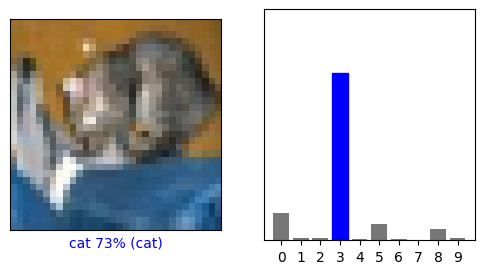

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

## Use the trained model

Finally, use the trained model to make a prediction about a single image.

In [ ]:
img = tf.keras.utils.load_img("./test_image.jpg", target_size=(32,32)#download your own image
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Add the image to a batch where it's the only member.


predictions = model.predict(img_array)
score = predictions[0]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 13ms/step
This image most likely belongs to airplane with a 100.00 percent confidence.
